In [1]:
library(SBC);
library(cmdstanr);
library(jsonlite);
library(tidyverse);
options(mc.cores = parallel::detectCores());
library(future);
plan(multisession);

options(SBC.min_chunk_size = 5);

cache_dir <- "./SBC_cache"
if(!dir.exists(cache_dir)) {
    dir.create(cache_dir)
}

ALPHA <- 0.05
model_BT_1 <- cmdstanr::cmdstan_model("../models/BT_model_1.stan")
model_BT_2 <- cmdstanr::cmdstan_model("../models/BT_model_2.stan")


This is cmdstanr version 0.7.1

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: /Users/igor.michels/.cmdstan/cmdstan-2.34.1

- CmdStan version: 2.34.1


A newer version of CmdStan is available. See ?install_cmdstan() to install it.
To disable this check set option or environment variable CMDSTANR_NO_VER_CHECK=TRUE.

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.0     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter()  masks stats::filter()
x purrr::flatten() masks jsonlite::flatten()
x dplyr::lag()     masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
N_SIMS <- 50
N_CLUBS <- 20
N_ITER_WARMUP <- 200
N_ITER_SAMPLING <- 300
N_CHAINS <- 4

In [3]:
data_generator_single_BT_1 <- function(n_clubs){
    n_seasons <- 1
    clubs <- sprintf("Club %02d", 1:n_clubs)
    clubs <- 1:n_clubs
    force <- rnorm(length(clubs))
    df <- data.frame(Club = clubs, Force = force)
    data <- merge(df, df, by = NULL) %>% filter(Club.x != Club.y)
    data$prob.home <- exp(data$Force.x) / (exp(data$Force.x) + exp(data$Force.y))
    data$home.wins <- 0

    for (i in 1:n_seasons) {
        data$random <- runif(n_clubs * (n_clubs - 1))
        data$home.wins <- data$home.wins + (data$random <  data$prob.home) * 1
    }

    data$away.wins <- n_seasons - data$home.wins
    data <- subset(data, select = -random)
    data <- subset(data, select = -prob.home)
    names(data) <- c("home_name", "home_force", "away_name", "away_force",
                     "home_wins", "away_wins")

    list(
        variables = list(
            skill = force
        ),
        generated = list(
            num_games = nrow(data),
            num_teams = n_clubs,
            team1 = data$home_name,
            team2 = data$away_name,
            team1_win = data$home_wins
        )
    )
}

In [4]:
data_generator_single_BT_2 <- function(n_clubs){
    n_seasons <- 1
    clubs <- sprintf("Club %02d", 1:n_clubs)
    clubs <- 1:n_clubs
    force <- rnorm(length(clubs))
    home_force <- rnorm(1)
    df <- data.frame(Club = clubs, Force = force)
    data <- merge(df, df, by = NULL) %>% filter(Club.x != Club.y)
    data$prob.home <- exp(data$Force.x + home_force) / (exp(data$Force.x) + exp(data$Force.y))
    data$home.wins <- 0

    for (i in 1:n_seasons) {
        data$random <- runif(n_clubs * (n_clubs - 1))
        data$home.wins <- data$home.wins + (data$random <  data$prob.home) * 1
    }

    data$away.wins <- n_seasons - data$home.wins
    data <- subset(data, select = -random)
    data <- subset(data, select = -prob.home)
    names(data) <- c("home_name", "home_force", "away_name", "away_force",
                     "home_wins", "away_wins")

    list(
        variables = list(
            skill = force,
            home_advantage = home_force
        ),
        generated = list(
            num_games = nrow(data),
            num_teams = n_clubs,
            team1 = data$home_name,
            team2 = data$away_name,
            team1_win = data$home_wins
        )
    )
}

In [5]:
set.seed(0)
data_generator_BT_1 <- SBC_generator_function(data_generator_single_BT_1, n_clubs = N_CLUBS)
dataset_BT_1 <- generate_datasets(data_generator_BT_1, N_SIMS)
backend_BT_1 <- SBC_backend_cmdstan_sample(model_BT_1, iter_warmup = N_ITER_WARMUP,
                                           iter_sampling = N_ITER_SAMPLING, chains = N_CHAINS)

results_BT_1 <- compute_SBC(dataset_BT_1, backend_BT_1,
                            cache_mode = "results",
                            cache_location = file.path(cache_dir, "results_BT_1"))

write.csv(results_BT_1$stats,
          file = "SBC_cache/results_BT_1.csv")

Results loaded from cache file 'results_BT_1'

 - 50 (100%) fits had at least one Rhat > 1.01. Largest Rhat was 4.488.

 - 50 (100%) fits had tail ESS undefined or less than half of the maximum rank, potentially skewing 
the rank statistics. The lowest tail ESS was 11.
 If the fits look good otherwise, increasing `thin_ranks` (via recompute_SBC_statistics) 
or number of posterior draws (by refitting) might help.

 - 50 (100%) fits had iterations that saturated max treedepth. Maximum number of max treedepth was 1200.

Not all diagnostics are OK.
You can learn more by inspecting $default_diagnostics, $backend_diagnostics 
and/or investigating $outputs/$messages/$warnings for detailed output from the backend.



In [6]:
set.seed(0)
data_generator_BT_2 <- SBC_generator_function(data_generator_single_BT_2, n_clubs = N_CLUBS)
dataset_BT_2 <- generate_datasets(data_generator_BT_2, N_SIMS)
backend_BT_2 <- SBC_backend_cmdstan_sample(model_BT_2, iter_warmup = N_ITER_WARMUP,
                                           iter_sampling = N_ITER_SAMPLING, chains = N_CHAINS)

results_BT_2 <- compute_SBC(dataset_BT_2, backend_BT_2,
                            cache_mode = "results",
                            cache_location = file.path(cache_dir, "results_BT_2"))
    
write.csv(results_BT_2$stats,
          file = "SBC_cache/results_BT_2.csv")

Results loaded from cache file 'results_BT_2'

 - 50 (100%) fits had at least one Rhat > 1.01. Largest Rhat was 4.512.

 - 50 (100%) fits had tail ESS undefined or less than half of the maximum rank, potentially skewing 
the rank statistics. The lowest tail ESS was 11.
 If the fits look good otherwise, increasing `thin_ranks` (via recompute_SBC_statistics) 
or number of posterior draws (by refitting) might help.

 - 50 (100%) fits had iterations that saturated max treedepth. Maximum number of max treedepth was 1200.

Not all diagnostics are OK.
You can learn more by inspecting $default_diagnostics, $backend_diagnostics 
and/or investigating $outputs/$messages/$warnings for detailed output from the backend.



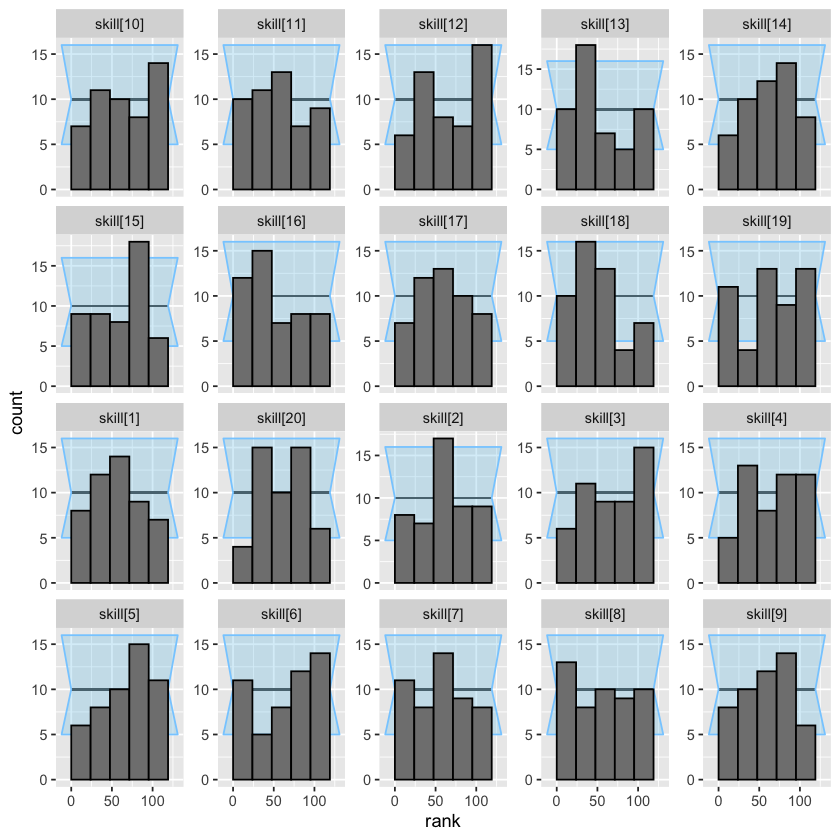

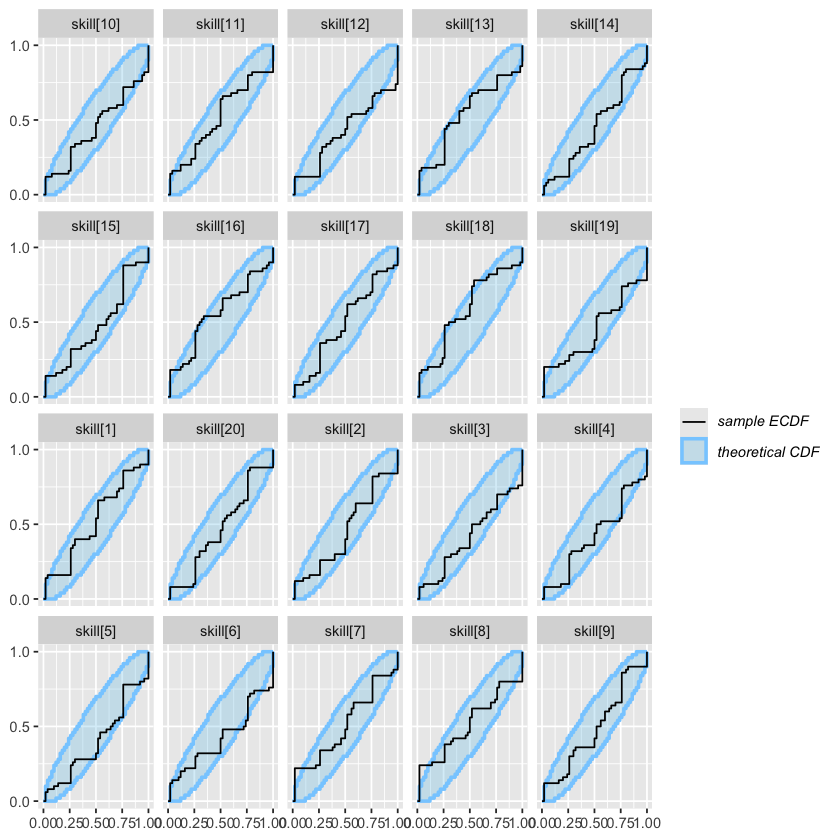

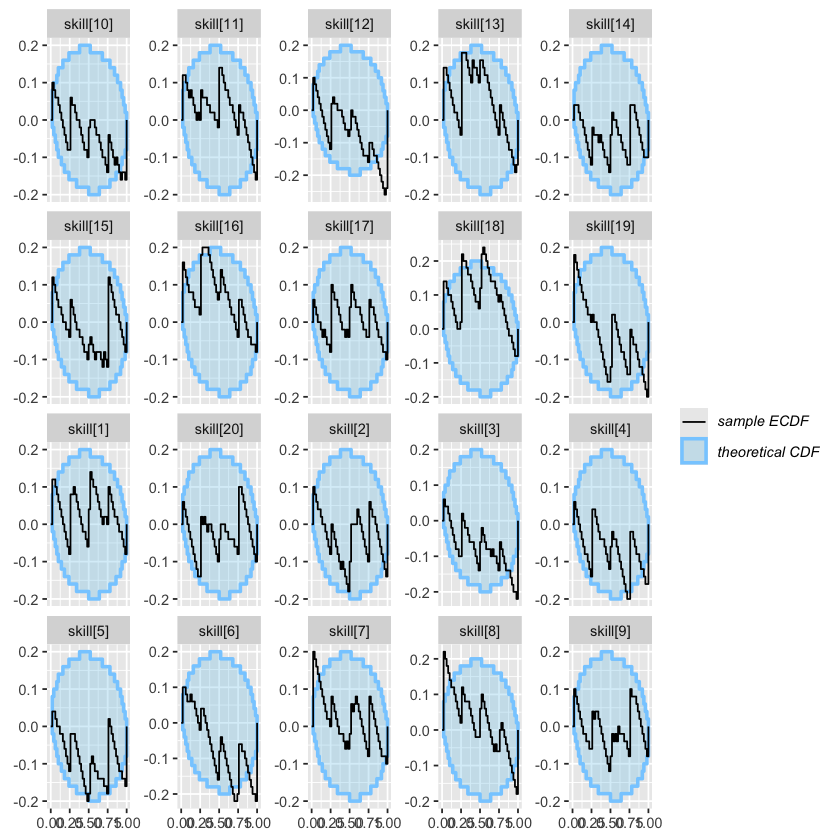

In [7]:
plot_rank_hist(results_BT_1)
plot_ecdf(results_BT_1)
plot_ecdf_diff(results_BT_1)

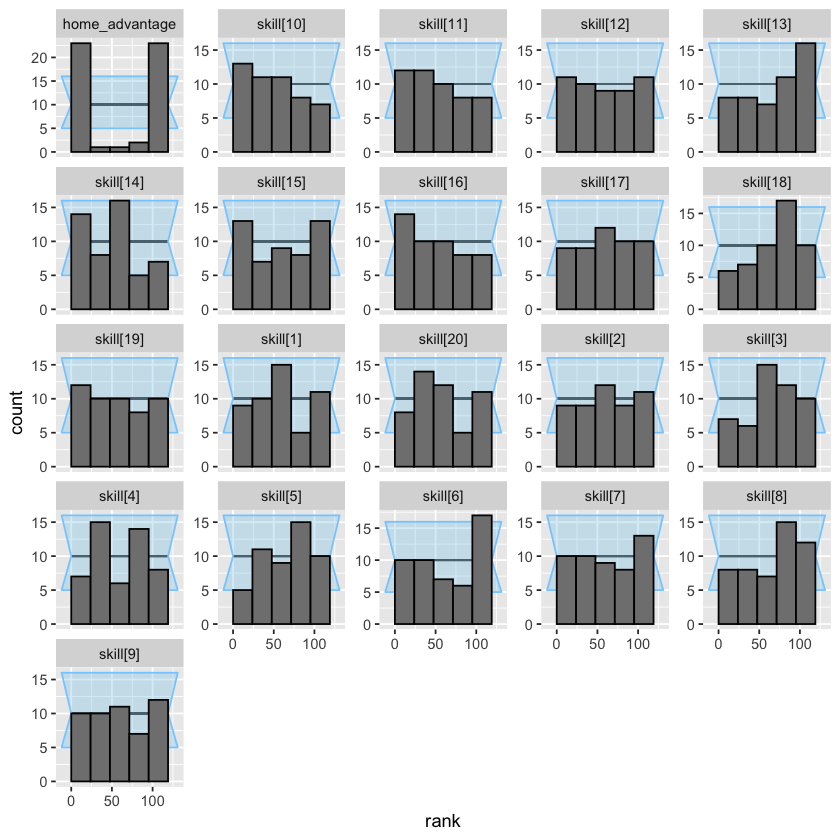

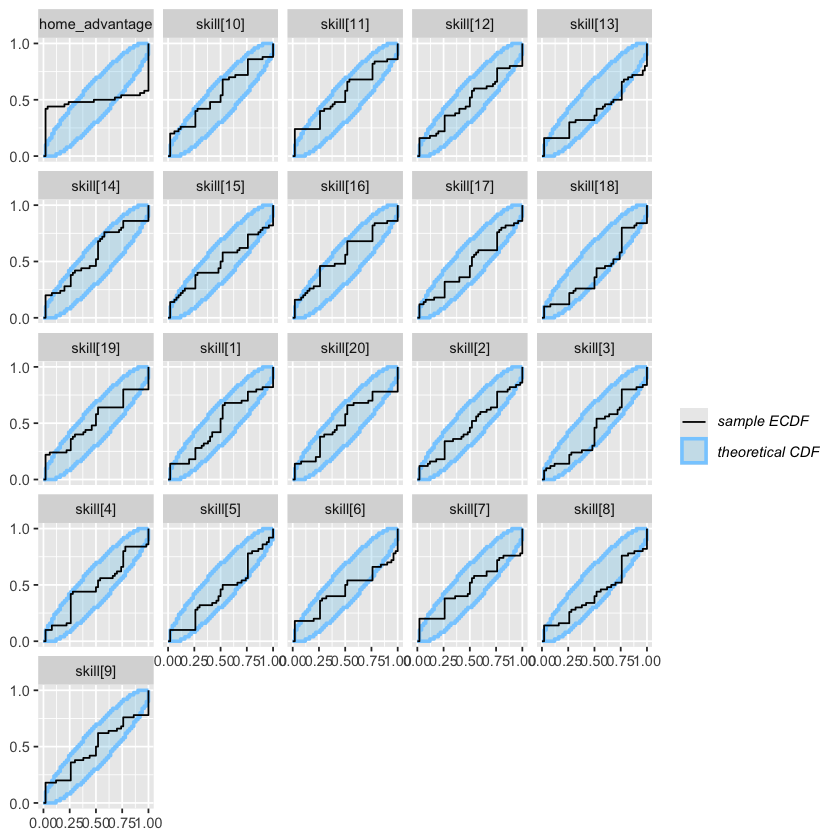

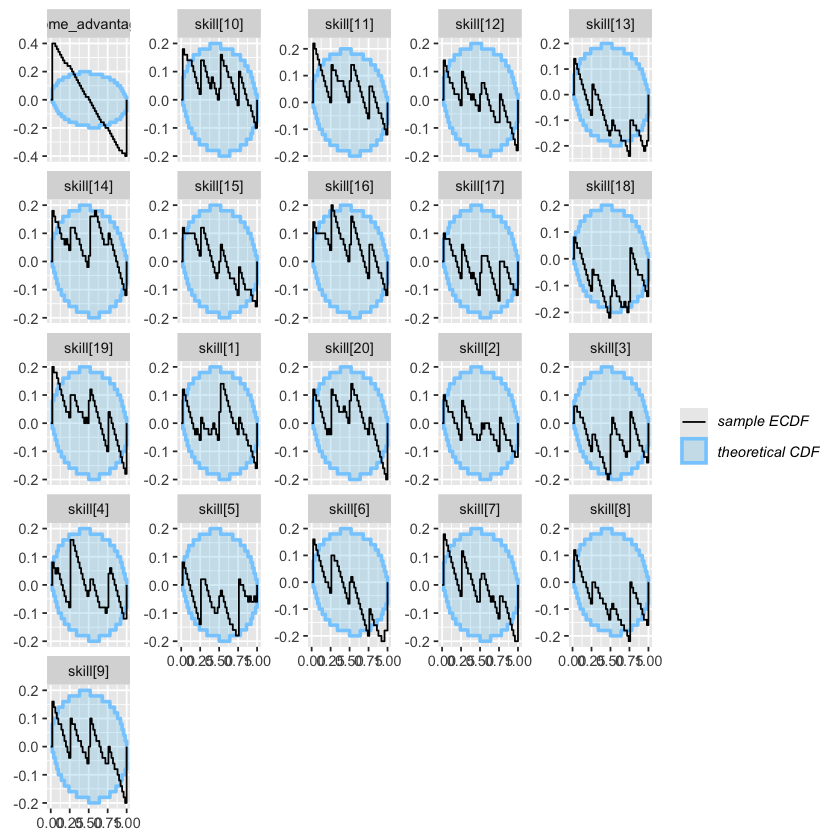

In [8]:
plot_rank_hist(results_BT_2)
plot_ecdf(results_BT_2)
plot_ecdf_diff(results_BT_2)

In [9]:
results <- results_BT_1
graph <- plot_ecdf(results)
plot_data <- ggplot_build(graph)$data
confidence_interval <- plot_data[[1]]
ecdf <- plot_data[[2]]

df1 <- merge(select(confidence_interval, - c(colour, fill, group, flipped_aes, linewidth, linetype, alpha, y)),
             select(ecdf, - c(colour, fill, group, linewidth, linetype, alpha)),
             by = c("PANEL", "x"), all.x = TRUE) %>%
       group_by(PANEL, x) %>%
       summarize(ymax = max(ymax, na.rm = TRUE),
                 ymin = max(ymin, na.rm = TRUE),
                 y = max(y, na.rm = TRUE))

df1$out <- (df1$ymax < df1$y) + (df1$ymin > df1$y)
df1 <- df1 %>% group_by(PANEL) %>% summarise(out_ratio = sum(out))
df1$out_ratio <- df1$out_ratio / length(unique(ecdf$x))
df1$out <- df1$out_ratio > ALPHA

graph <- plot_ecdf_diff(results)
plot_data <- ggplot_build(graph)$data
confidence_interval <- plot_data[[1]]
ecdf <- plot_data[[2]]

df2 <- merge(select(confidence_interval, - c(colour, fill, group, flipped_aes, linewidth, linetype, alpha, y)),
             select(ecdf, - c(colour, fill, group, linewidth, linetype, alpha)),
             by = c("PANEL", "x"), all.x = TRUE) %>%
       group_by(PANEL, x) %>%
       summarize(ymax = max(ymax, na.rm = TRUE),
                 ymin = max(ymin, na.rm = TRUE),
                 y = max(y, na.rm = TRUE))

df2$out <- (df2$ymax < df2$y) + (df2$ymin > df2$y)
df2 <- df2 %>% group_by(PANEL) %>% summarise(out_ratio = sum(out))
df2$out_ratio <- df2$out_ratio / length(unique(ecdf$x))
df2$out <- df2$out_ratio > ALPHA

final_df <- merge(df1, df2, by = "PANEL", suffixes = c("", "_diff"))
c(mean(as.numeric(final_df$out)), mean(as.numeric(final_df$out_diff)))

`summarise()` has grouped output by 'PANEL'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'PANEL'. You can override using the
`.groups` argument.


[1] 0.7 0.7

In [10]:
results <- results_BT_2
graph <- plot_ecdf(results)
plot_data <- ggplot_build(graph)$data
confidence_interval <- plot_data[[1]]
ecdf <- plot_data[[2]]

df1 <- merge(select(confidence_interval, - c(colour, fill, group, flipped_aes, linewidth, linetype, alpha, y)),
             select(ecdf, - c(colour, fill, group, linewidth, linetype, alpha)),
             by = c("PANEL", "x"), all.x = TRUE) %>%
       group_by(PANEL, x) %>%
       summarize(ymax = max(ymax, na.rm = TRUE),
                 ymin = max(ymin, na.rm = TRUE),
                 y = max(y, na.rm = TRUE))

df1$out <- (df1$ymax < df1$y) + (df1$ymin > df1$y)
df1 <- df1 %>% group_by(PANEL) %>% summarise(out_ratio = sum(out))
df1$out_ratio <- df1$out_ratio / length(unique(ecdf$x))
df1$out <- df1$out_ratio > ALPHA

graph <- plot_ecdf_diff(results)
plot_data <- ggplot_build(graph)$data
confidence_interval <- plot_data[[1]]
ecdf <- plot_data[[2]]

df2 <- merge(select(confidence_interval, - c(colour, fill, group, flipped_aes, linewidth, linetype, alpha, y)),
             select(ecdf, - c(colour, fill, group, linewidth, linetype, alpha)),
             by = c("PANEL", "x"), all.x = TRUE) %>%
       group_by(PANEL, x) %>%
       summarize(ymax = max(ymax, na.rm = TRUE),
                 ymin = max(ymin, na.rm = TRUE),
                 y = max(y, na.rm = TRUE))

df2$out <- (df2$ymax < df2$y) + (df2$ymin > df2$y)
df2 <- df2 %>% group_by(PANEL) %>% summarise(out_ratio = sum(out))
df2$out_ratio <- df2$out_ratio / length(unique(ecdf$x))
df2$out <- df2$out_ratio > ALPHA

final_df <- merge(df1, df2, by = "PANEL", suffixes = c("", "_diff"))
c(mean(as.numeric(final_df$out)), mean(as.numeric(final_df$out_diff)))

`summarise()` has grouped output by 'PANEL'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'PANEL'. You can override using the
`.groups` argument.


[1] 0.8571429 0.8571429

In [11]:
run_BT_model <- function(year) {
    output_path <- paste0("../results/results_BT_1_", year, ".csv")
    if (!file.exists(output_path)) {
        data <- read_json(paste0('../real_data/BT_model_data_', year, '.json'))
        data[["teams"]] <- NULL
        
        capture.output({
            fit_BT_1 <- suppressMessages(
                suppressWarnings(
                    model_BT_1$sample(
                        data = data,
                        chains = N_CHAINS,
                        parallel_chains = N_CHAINS,
                        refresh = 500
                    )
                )
            )
        })

        results_BT_1 <- fit_BT_1$summary(
            variables = NULL,
            posterior::default_summary_measures(),
            extra_quantiles = ~posterior::quantile2(., probs = c(.0275, .975))
        )

        write.csv(results_BT_1, file = output_path, row.names = FALSE)
    }

    output_path <- paste0("../results/results_BT_2_", year, ".csv")
    if (!file.exists(output_path)) {
        data <- read_json(paste0('../real_data/BT_model_data_', year, '.json'))
        data[["teams"]] <- NULL
        
        capture.output({
            fit_BT_2 <- suppressMessages(
                suppressWarnings(
                    model_BT_2$sample(
                        data = data,
                        chains = N_CHAINS,
                        parallel_chains = N_CHAINS,
                        refresh = 500
                    )
                )
            )
        })

        results_BT_2 <- fit_BT_2$summary(
            variables = NULL,
            posterior::default_summary_measures(),
            extra_quantiles = ~posterior::quantile2(., probs = c(.0275, .975))
        )

        write.csv(results_BT_2, file = output_path, row.names = FALSE)
    }
}

In [12]:
for (year in 2019:2023) {
    run_BT_model(year)
    message(paste("Completed processing for year", year))
}

Completed processing for year 2019

Completed processing for year 2020

Completed processing for year 2021

Completed processing for year 2022

Completed processing for year 2023

